In [189]:
from copy import deepcopy
from scipy.stats.mstats import mquantiles

from chase.base import *
from chase.utils import *
from chase.fit import *

pd.set_option('display.max_colwidth', 100)

# Load data for Hau et al. (2008)

The `group` column in the data refers to the experiment (1 or 2).

In [238]:
arr = np.genfromtxt('hau_problems.csv', delimiter=',')
problems = {i: arr[i].reshape((2,2,2)) for i in range(len(arr))}
data = pd.read_csv('hau_data.csv', index_col=0)
data.head(10)

,subject,problem,choice,group,samplesize
6,1,0,0,1,19
4,1,1,1,1,38
1,1,2,0,1,18
5,1,3,1,1,16
3,1,4,0,1,24
2,1,5,0,1,47
10,2,0,0,1,2
9,2,1,0,1,2
11,2,2,0,1,2
7,2,3,1,1,3


# Fit experiment 1

In [301]:
# a list of possible free parameters and their ranges
# and starting point (optional)
PARS = {'theta': [2, 6],
        'p_stay': [0, 1],
        'tau': [0, 40, 1.],
        'prelec_gamma': [0, 5],
        'prelec_elevation': [0, 5],
        'pow_gain': [0., np.inf, 1.],
        'w_loss': [0., np.inf, 1.]}

# parameters that are set to fixed values 
FIXED = {'delta': 0.5,
         'minsamplesize': 2}

N_ITER = 5
SIM_ID = 'hau_exp1'
OUTDIR = 'chase_fitresults_hau2008'

# a list of different parameter combinations that will
# be fit
PARSETS = [['theta', 'p_stay', 'tau'],
           ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
           ['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
           ['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation', 'pow_gain', 'w_loss']]

In [ ]:
for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    
    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='softmax')
        
    # fit
    results = fit_mlh(m, problems, data[data.group==1], 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)
    
    #print results.sort('nllh')

In [310]:
# create a table summarizing the best-fitting result for each parameter
# combination
allresults = pd.DataFrame(columns=['sim_id', 'k', 'N', 'nllh', 'bic'])
for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    allresults.loc[allresults.shape[0]] = best_result('hau_exp1', FIXED, fitting, outdir=OUTDIR, nopars=True)
allresults.to_csv('hau_exp1_fitsummary.csv')
allresults.sort('bic')

,sim_id,k,N,nllh,bic
1,"hau_exp1(p_stay,prelec_elevation,prelec_gamma,tau,theta|delta=0.5,minsamplesize=2)",5,230,944.340776,1915.871949
2,"hau_exp1(p_stay,pow_gain,tau,theta,w_loss|delta=0.5,minsamplesize=2)",5,230,944.605018,1916.400432
3,"hau_exp1(p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta,w_loss|delta=0.5,minsamplesize=2)",7,230,943.501731,1925.070017
0,"hau_exp1(p_stay,tau,theta|delta=0.5,minsamplesize=2)",3,230,972.113831,1960.541899


In [311]:
# show the fitting results for the model with the lowest BIC
fitting = {p: PARS[p] for p in PARSETS[1]}
best_result('hau_exp1', FIXED, fitting, outdir=OUTDIR)

index                          6
Unnamed: 0                     6
iteration                      1
success                     True
nllh                    944.3408
k                              5
N                            230
bic                     1915.872
theta                          3
prelec_gamma            1.153518
prelec_elevation        1.610244
p_stay                 0.4882577
tau                 9.692683e-05
Name: 0, dtype: object

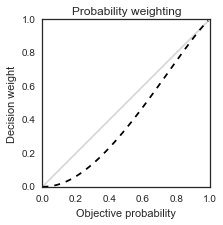

In [251]:
def prelec(p, prelec_elevation, prelec_gamma):
    return np.exp(-prelec_elevation * ((-np.log(p)) ** prelec_gamma))

p = np.arange(0, 1, .01)
fig, axi = plt.subplots(figsize=(3,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
axi.plot(p, prelec(p, 1.61, 1.15), '--', color='black')
axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.show()

In [312]:
# for the model with lowest BIC, run the model and get the 
# predicted choice proportions and sample size distribution
m = CHASEModel(drift='cpt', startdist='softmax')
pred = predict_from_result(m, problems, 'hau_exp1', FIXED, fitting = {p: PARS[p] for p in PARSETS[1]}, 
                           outdir=OUTDIR)

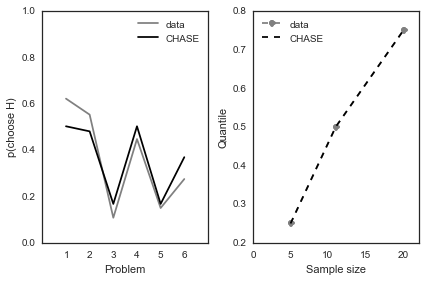

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
axi = ax[0]
axi.plot(range(1, 7), data[data.group==1].groupby('problem').apply(lambda d: np.mean(d.choice)),
         color='gray', label='data')
axi.plot(range(1, 7), [pred[pid]['p_resp'][1] for pid in problems], color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
mq = mquantiles(data[data.group==1].samplesize)
axi.plot(mq, [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(pred_quantiles(pred) + 2, [.25, .5, .75], '--x', color='black', label='CHASE')
axi.set_xlim(0, mq[-1] + 2)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')


plt.tight_layout()
plt.show()

# Fit experiment 2

In [ ]:
SIM_ID = 'hau_exp2'

for parset in PARSETS:

    fitting = {p: PARS[p] for p in parset}
    
    # initialize the model
    m = CHASEModel(drift='cpt',
                   startdist='softmax')
        
    # fit
    results = fit_mlh(m, problems, data[data.group==2], 
                      SIM_ID, FIXED, fitting, niter=N_ITER, outdir=OUTDIR)
    
    #print results.sort('nllh')

In [305]:
allresults = pd.DataFrame(columns=['sim_id', 'k', 'N', 'nllh', 'bic'])
for parset in PARSETS:
    fitting = {p: PARS[p] for p in parset}
    allresults.loc[allresults.shape[0]] = best_result('hau_exp2', FIXED, fitting, outdir=OUTDIR, nopars=True)
allresults.to_csv('hau_exp2_fitsummary.csv')
allresults.sort('bic')

,sim_id,k,N,nllh,bic
1,"hau_exp2(p_stay,prelec_elevation,prelec_gamma,tau,theta|delta=0.5,minsamplesize=2)",5,234,1239.194292,2505.665189
2,"hau_exp2(p_stay,pow_gain,tau,theta,w_loss|delta=0.5,minsamplesize=2)",5,234,1239.917515,2507.111635
0,"hau_exp2(p_stay,tau,theta|delta=0.5,minsamplesize=2)",3,234,1245.451564,2507.269091
3,"hau_exp2(p_stay,pow_gain,prelec_elevation,prelec_gamma,tau,theta,w_loss|delta=0.5,minsamplesize=2)",7,234,1239.185993,2516.559235


In [306]:
fitting = {p: PARS[p] for p in PARSETS[1]}
best_result('hau_exp2', FIXED, fitting, outdir=OUTDIR)

index                      18
Unnamed: 0                 18
iteration                   3
success                  True
nllh                 1239.194
k                           5
N                         234
bic                  2505.665
theta                       5
p_stay              0.4631854
prelec_elevation     1.300885
prelec_gamma        0.9170127
tau                 0.4056709
Name: 0, dtype: object

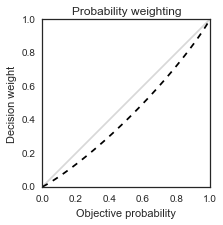

In [307]:
p = np.arange(0, 1, .01)
fig, axi = plt.subplots(figsize=(3,3))
axi.plot([0, 1], [0, 1], color='gray', alpha=.3)
axi.plot(p, prelec(p, 1.3, .92), '--', color='black')
axi.set_title('Probability weighting')
axi.set_xlabel('Objective probability')
axi.set_ylabel('Decision weight')
plt.show()

In [308]:
m = CHASEModel(drift='cpt', startdist='softmax')
pred = predict_from_result(m, problems, 'hau_exp2', FIXED, fitting = {p: PARS[p] for p in PARSETS[1]}, 
                           outdir=OUTDIR)

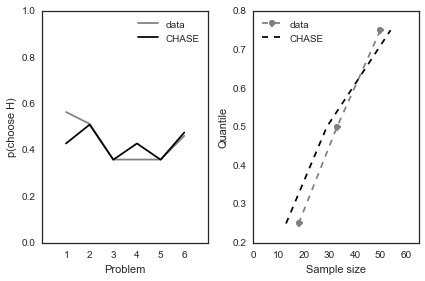

In [309]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
axi = ax[0]
axi.plot(range(1, 7), data[data.group==2].groupby('problem').apply(lambda d: np.mean(d.choice)),
         color='gray', label='data')
axi.plot(range(1, 7), [pred[pid]['p_resp'][1] for pid in problems], color='black', label='CHASE')
axi.set_ylim(0, 1)
axi.set_xlim(0, 7)
axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
mq = mquantiles(data[data.group==2].samplesize)
axi.plot(mq, [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(pred_quantiles(pred) + 2, [.25, .5, .75], '--x', color='black', label='CHASE')
axi.set_xlim(0, mq[-1] + 15)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')


plt.tight_layout()
plt.show()